BERT, Classfication layer - MED + Epochs

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


train_data = pd.read_csv('../datasets/data_train.csv')
test_data = pd.read_csv('../datasets/data_test.csv')
valid_data = pd.read_csv('../datasets/data_valid.csv')

all_labels = pd.concat([train_data["label"], test_data["label"], valid_data["label"]])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

LabelEncoder()

In [2]:
def extract_texts_labels(data, label_encoder):
    texts = data['data'].values
    labels = data['label'].values
    encoded_labels = label_encoder.transform(labels)
    return texts, encoded_labels

In [3]:
train_texts, train_labels = extract_texts_labels(train_data, label_encoder)
test_texts, test_labels = extract_texts_labels(test_data, label_encoder)
valid_texts, valid_labels = extract_texts_labels(valid_data, label_encoder)


In [4]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("GerMedBERT/medbert-512")

# Tokenize the data
train_encodings = tokenizer(train_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)
test_encodings = tokenizer(test_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)
valid_encodings = tokenizer(valid_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)

In [5]:
import tensorflow as tf

def create_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    return dataset

train_dataset = create_dataset(train_encodings, train_labels)
test_dataset = create_dataset(test_encodings, test_labels)
valid_dataset = create_dataset(valid_encodings, valid_labels)

2024-07-28 00:55:21.534972: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-28 00:55:21.534996: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-28 00:55:21.535004: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-28 00:55:21.535016: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-28 00:55:21.535028: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
from transformers import TFBertForSequenceClassification

# Load the BERT model for sequence classification with the number of output labels
model = TFBertForSequenceClassification.from_pretrained("GerMedBERT/medbert-512", num_labels=len(label_encoder.classes_))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[ "accuracy" ]
)


In [8]:
# Train the model with early stopping callback
model.fit(train_dataset.shuffle(1000).batch(64),
          validation_data=valid_dataset.batch(64),
          epochs=10)


Epoch 1/10


2024-07-28 00:55:48.753819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


368/368 [==============================] - 1633s 4s/step - loss: 1.1459 - accuracy: 0.4827 - val_loss: 1.0987 - val_accuracy: 0.5166
Epoch 2/10
368/368 [==============================] - 1625s 4s/step - loss: 1.0638 - accuracy: 0.5397 - val_loss: 1.0759 - val_accuracy: 0.5375
Epoch 3/10
368/368 [==============================] - 1636s 4s/step - loss: 0.9761 - accuracy: 0.5912 - val_loss: 1.0535 - val_accuracy: 0.5621
Epoch 4/10
368/368 [==============================] - 1632s 4s/step - loss: 0.8517 - accuracy: 0.6567 - val_loss: 1.0468 - val_accuracy: 0.5932
Epoch 5/10
368/368 [==============================] - 1624s 4s/step - loss: 0.7146 - accuracy: 0.7189 - val_loss: 1.0169 - val_accuracy: 0.6316
Epoch 6/10
368/368 [==============================] - 1622s 4s/step - loss: 0.5920 - accuracy: 0.7712 - val_loss: 1.0539 - val_accuracy: 0.6542
Epoch 7/10
368/368 [==============================] - 1621s 4s/step - loss: 0.4915 - accuracy: 0.8113 - val_loss: 1.1008 - val_accuracy: 0.6702
Epo

In [9]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset.batch(32))
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

246/246 [==============================] - 162s 657ms/step - loss: 1.0602 - accuracy: 0.7261
Loss: 1.0601952075958252
Accuracy: 0.7260903120040894


In [10]:
model.save_pretrained('bert_classify_med')
tokenizer.save_pretrained('bert_classify_tokenizer_med')

('bert_classify_tokenizer_med/tokenizer_config.json',
 'bert_classify_tokenizer_med/special_tokens_map.json',
 'bert_classify_tokenizer_med/vocab.txt',
 'bert_classify_tokenizer_med/added_tokens.json')

In [11]:
import numpy as np
predictions = model.predict(test_dataset.batch(32))
predicted_labels = np.argmax(predictions.logits, axis=-1)

# Decode class labels to original labels
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# True labels from the test set
true_labels = label_encoder.inverse_transform(test_labels)

# Create a DataFrame to compare
comparison_df = pd.DataFrame({'Text': test_texts, 'True Label': true_labels, 'Predicted Label': decoded_predictions})

246/246 [==============================] - 152s 608ms/step


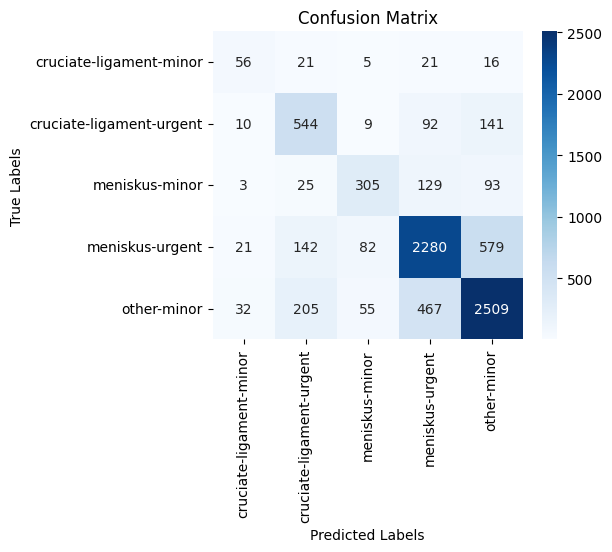

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, decoded_predictions, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

 cruciate-ligament-minor       0.46      0.47      0.46       119
cruciate-ligament-urgent       0.58      0.68      0.63       796
          meniskus-minor       0.67      0.55      0.60       555
         meniskus-urgent       0.76      0.73      0.75      3104
             other-minor       0.75      0.77      0.76      3268

                accuracy                           0.73      7842
               macro avg       0.64      0.64      0.64      7842
            weighted avg       0.73      0.73      0.73      7842



In [14]:
from sklearn.metrics import classification_report
report = classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("almost_final.csv")